# Neural Style Transfer 

Bu noktebookta kullanılan başlıca kaynak (aslında herkesin öyle) şu makaledir:
[Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

Neural Style Transfer konusuna geçmeden önce aşağıda ki 2 fotoğrafı yorumlamanızı ve neresi olabiliceğini düşünmenizi rica ediyorum.

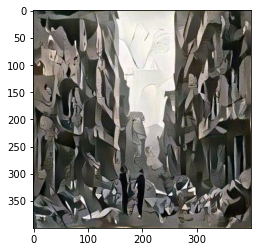

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('1.jpg'))

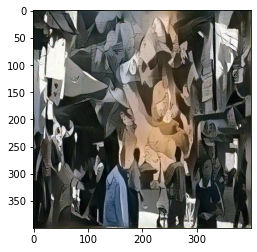

In [2]:
plt.imshow(mpimg.imread('2.jpg'))

### Giriş
Herşey yukarıda bağlantısını verdiğim makalenin yayınlanmasıyla başladı. Gatys ve dostları sanatsal üslubun bir resimden başka bir resme, evrişimsel sinir ağlarını kullanarak aktarmasını anatan bir makale yayınladılar. Onlara göre sanat eseri olan içeriği ve hedef içeriğimizden biraz kayıp vererek birleştirmek ve ortaya yeni bir ürün çıkarmak mümkündü ki öylede oldu.
Dilerseniz herkesin merak ettiği kısma geçelim.

## Neural Style Transfer'in Mantığı Ve Teknik Kısmı

Öncelikle 2 adet inputumuz olmak zorunda.
Bunlardan ilki Content,giriş,hedef resim olarak adlandırılan inputtur. Aşağıda ki resim ise bizim hedef inputumuz

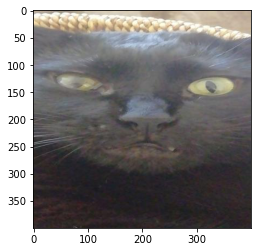

In [3]:
plt.imshow(mpimg.imread('input-hedef.jpg'))

Diğer inputumuz ise Stil resim olarak anılmakta. Yani hedef resmimize monte edeceğimiz dokunun sahibi olan resim.Aşağıda ki resim ise bizim Stil inputumuz

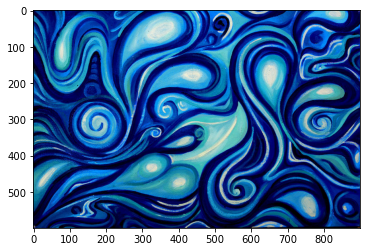

In [4]:
plt.imshow(mpimg.imread('input-Still .jpg'))

Output olarak ise aşağıdaki görüntüyü elde ediyoruz

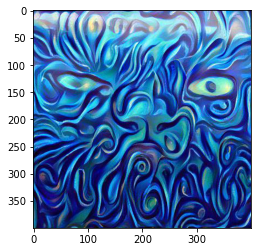

In [5]:
plt.imshow(mpimg.imread('Kömür-output.jpg'))

## Modele Kabaca bakacak olusak;

<img src='https://raw.githubusercontent.com/shikharvaish28/neural-style/master/assets/vgg19_convlayers.png' width=100% />



Burada görmüş olduğunuz Gatsy ve arkadaşlarının kurduğu modeli görüyorsunuz. Bu makalede, stil aktarımı, bir dizi conv layer, Full connected layers ve pooling layerdan  oluşan VGG19 kullandılar. Bunun neeni modelin basit yapıda olması , özellik haritaları ve stil aktarımı için daha iyi çalışmasıdır. Ve mimarileri yukarıdaki gibiydi. Temel olarak kavradığımıza göre kodlayarak ve anlatarak devam edelim.

### Kütüphaneleri import etmek
Ben kendim kullandığım PyTorch,CUDA ve cuDNN versiyonlarını aşağıdaki gibidir. Başka versiyonlarda çok sıkıntı olacağını sanmam ama sürümden kaynaklı bir hata alırsanız böyle deneyebilirsiniz.

In [6]:
import torch
from PIL import Image
import os
from collections import namedtuple

import torch
from torchvision import models

from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import time

print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

PyTorch version: 
1.5.1
CUDA Version: 
10.1
cuDNN version is: 
7604


Tahmin edersinizki önce resimlerimizi yüklemeliyiz. Resimlerin boyutlarını sonradan belirleyeceğimiz için onları "IMAGE_HEIGHT, IMAGE_WIDTH" olarak 2 değişkene atadım. Küçük resimler için ANTIALIAS daha iyi olduğu için onu kullandım ve daha yeni sürümlerde "LANCZOS" olarak yeniden adlandırıldı.

In [7]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(IMAGE_HEIGHT / scale), int(IMAGE_WIDTH / scale)), Image.ANTIALIAS)
    return img

Stil görüntüsünün temsilini elde etmek için, Gram Matrix’i kullanarak ağdaki farklı sinir türleri arasındaki korelasyonları hesaplamak gerekir.Genel olarak yükseklik, genişlik ve derinlik bilgileri evrişim katmanları sonucunda oluşan tensorü temsil eder ve bunlar öznitelik haritaları olarak adlandırılır. Özellik çıkarımı için oldukça kullanışlı bir matrixdir.

İsterseniz wikipediden bunu detaylıca öğrenebilirsiniz.

https://en.wikipedia.org/wiki/Gramian_matrix

Aşağıda ise Gram Matrix formülünü ve kodunu görmektesiniz. 

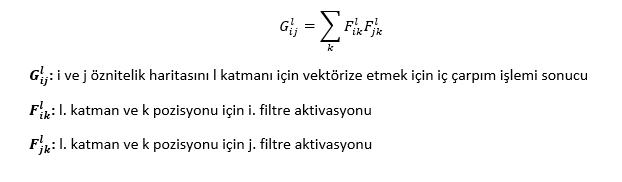

In [8]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

### Diğer gerekli olan fonksiyonların tanımlanması

In [9]:
def normalize_batch(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std


unloader = transforms.ToPILImage()

In [10]:
def save_image_epoch(tensor, path, num):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(os.path.join(path, "Output" + str(num) + '.png'))

In [11]:
def normalize(img):
    # normalize using imagenet mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).cuda()
    return (img - mean) / std

In [12]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()

        vgg_pretrained_features = models.vgg19(pretrained='imagenet').features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

Yukarıda görüldüğü gibi modelimizi kuruyoruz. VGG19 mu yoksa VGG16 mı kurmam gerek diye soracak iseniz cevap olarak şunu gösterebilirim.

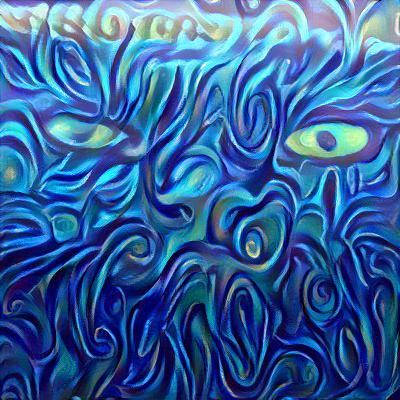


Bu Görüntü VGG16 ile 85.5 saniyede 1600 epoch sonucunda ortaya çıkan görünütüdür.

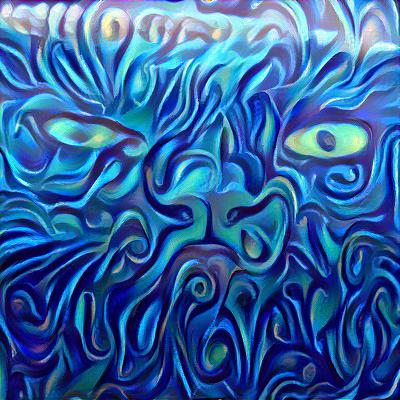

Bu Görüntü ise VGG19 ise 86 saniyede 1600 epoch sonucunda ortaya çıkan görüntü.

"Eee yani çok fark yok" diyorsanız  haklısınız. Ama ben VGG19'un kıvrımlarını daha çok beğendim. VGG16'da bir iki keskin kırıklar gözüme çarptı. Kısaca tamamiyle göz zevki. Öznel ve algı üzerine kurulu bir konu. Öte açıdan VGG19'un daha iyi performans vermesini beklersiniz.

## Ana fonksiyonu yazmak


Ana fonksiyonu yazmadan önce sizlere content loss ve style loss formüllerini paylaşmak istiyorum.

CONTENT LOSS/ VGG LOSS
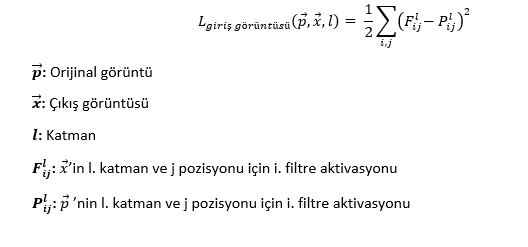

SYLE LOSS
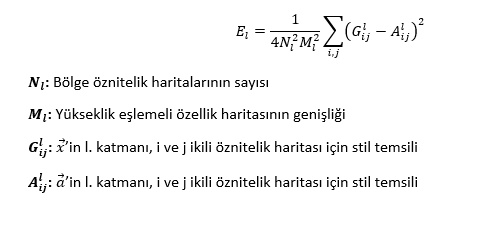

In [13]:
EPOCHS = 1401
STYLE_IMG_PATH = './style/style photo (43).jpg'
CONTENT_IMG_PATH = './content/DLTR.jpg'
OUTPUT_DIR = './output/'
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 400
IMAGE_SIZE  = IMAGE_WIDTH,IMAGE_HEIGHT
BATCH_SIZE = 1
LEARNING_RATE = 0.01
CONTENT_WEIGHT = 100
STYLE_WEIGHT = 10000000

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

style_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

vgg = Vgg19(requires_grad=False).cuda()  # vgg19 model

style_img = load_image(filename=STYLE_IMG_PATH, size=IMAGE_SIZE)
content_img = load_image(filename=CONTENT_IMG_PATH, size=IMAGE_SIZE)

style_img = style_transform(style_img)
content_img = transform(content_img)
#Yukarıda ki kısım fotoğraflarımızı yeniden şekil vermemize ve tensor'e çevirmemizi ve dönüştürmemizi sağlıyor
style_img = style_img.repeat(BATCH_SIZE, 1, 1, 1).cuda()  # make fake batch
content_img = content_img.repeat(BATCH_SIZE, 1, 1, 1).cuda() 
'''repeat, tensörü belirtilen boyutlar boyunca tekrar eder.

        Aksine expand(), bu işlev tensörün verilerini kopyalar.
        Daha fazlası için 
        https://pytorch.org/docs/stable/tensors.html
'''


features_style = vgg(style_img)  # Öznitelik haritası çıkarıyoruz
features_content = vgg(content_img)

gram_style = [gram_matrix(y) for y in features_style]  # gram matrix still öznitelikleri için

mse_loss = nn.MSELoss() # yukarıdaki loss ile farklı biliyorum  ama aşağısını bekleyin

y = content_img.detach()  # y hedef çıktımız. 
y = y.requires_grad_()  # ve onun gradientlerini hesaplıyoruz

optimizer = optim.Adam([y], lr=LEARNING_RATE)  

#optimizer = optim.LBFGS([y])
'''Çeşitli sebeplerden ötürü LBFGS, Adam ve diğerlerinden daha başarılı 
    
    Burada stokastik bir şey yoktur (farklı bir veri kümesine rastgele mini gruplar oluşturmuyoruz), 
    bunun yerine optimizasyon algoritması aynı tek görüntüyü elde etmeye devam edebilir.
    l-bfgs, Hessian’ın hesaplanması ve bir satır aramasının yapılmasıyla hangi yöne gidileceğini ve 
    o yönde gitmek için optimum mesafeyi belirler.
    
    Bu yaklaşım stokastik problemlerde maliyetlidir ancak burada doğru yaklaşımdır.
    En önemli ve son gerekçe de l-bfgs, stil transferinde Adam optimizasyonundan daha hızlı öğrenir.
    
    Diye anlatır Ayyüce Hoca
    
    Ama ben denediğimde siyah görüntü elde ettiğimden Adam kullandım'''

print("Eğlence Başlasın")
for epoch in range(EPOCHS):

    def closure():
        optimizer.zero_grad()
        y.data.clamp_(0, 1)
        features_y = vgg(y) # VGG'den çıkarılan y özellik haritaları
        gram_style_y = [gram_matrix(i) for i in features_y]  # relu 1_2,2_2,3_3,4_3'daki özelliklerin gram matrisi

        fc = features_content.relu4_3 # relu4_3içindeki hedef resimin 
        fy = features_y.relu4_3  # relu4_3 içindeki y

        style_loss = 0  # relu1_2,2_2,3_3,4_3 style loss ekleme
        for fy_gm, fs_gm in zip(gram_style_y, gram_style):
            style_loss += mse_loss(fy_gm, fs_gm)
        style_loss = STYLE_WEIGHT * style_loss

        content_loss = CONTENT_WEIGHT * mse_loss(fc, fy) 

        total_loss = content_loss + style_loss
        total_loss.backward(retain_graph=True)

        if epoch % 100 == 0:
            print("Epoch {}: Style Loss : {:4f} Content Loss: {:4f}".format(epoch, style_loss, content_loss))
        if epoch % 100 == 0:
            save_image_epoch(y, './outputs/', epoch)
        return total_loss
        # her 100 epochda 1, epoch style loss ve content loss bilgisi alıyoruz ve 1 resim kaydediliyor.

    optimizer.step(closure)


Eğlence Başlasın
Epoch 0: Style Loss : 243.699753 Content Loss: 0.000000
Epoch 100: Style Loss : 38.917847 Content Loss: 22.070475
Epoch 200: Style Loss : 31.669378 Content Loss: 20.479778
Epoch 300: Style Loss : 29.442347 Content Loss: 19.589470
Epoch 400: Style Loss : 29.385948 Content Loss: 18.174040
Epoch 500: Style Loss : 27.434486 Content Loss: 19.192570
Epoch 600: Style Loss : 28.605162 Content Loss: 17.477486
Epoch 700: Style Loss : 26.677147 Content Loss: 18.746679
Epoch 800: Style Loss : 27.087326 Content Loss: 17.833311
Epoch 900: Style Loss : 27.666296 Content Loss: 17.114155
Epoch 1000: Style Loss : 26.280556 Content Loss: 18.190529
Epoch 1100: Style Loss : 26.772526 Content Loss: 17.347063
Epoch 1200: Style Loss : 27.370920 Content Loss: 16.682737
Epoch 1300: Style Loss : 26.597996 Content Loss: 17.105646
Epoch 1400: Style Loss : 25.576519 Content Loss: 18.357985


content weight arttıkça yada style weight azaldıkça Hedef resime olan müdahale azalıcaktır. Tam tersi de geçerli. Yani hedef resminizi still fotoğrafınızdan farkı kalmayabilir. Aşağıda da bunun bir örneğini görüyorsunuz.

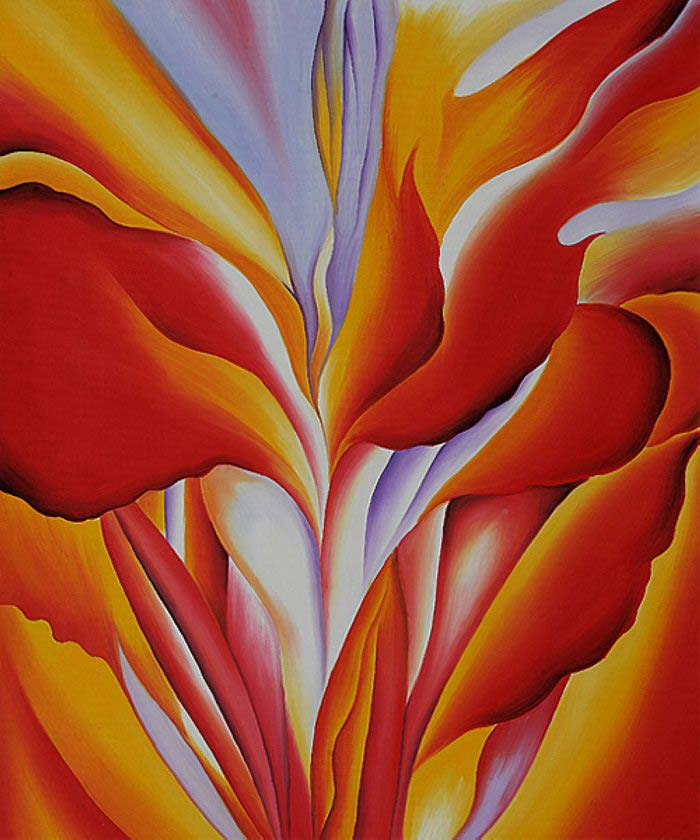

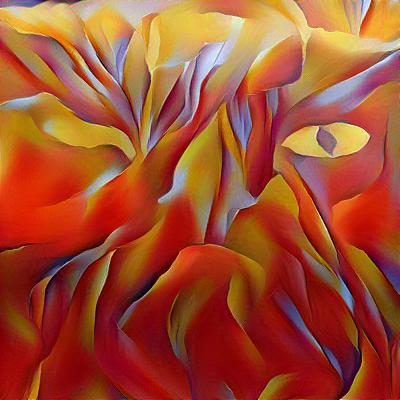

Böyle vakalar ile karşılaşmamanız için hiper parametreleri iyi ayarlamanız gerekmekte. Şimdi ise boyut farkının etkisine bakalım

400x400 olan ve 1600. epoch'un ürünü

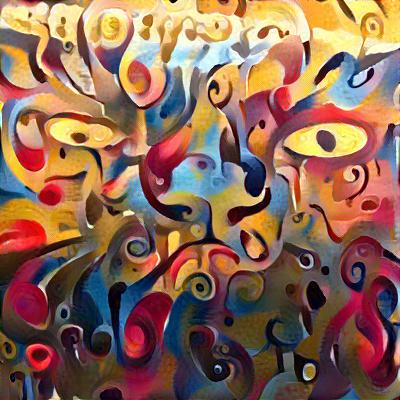

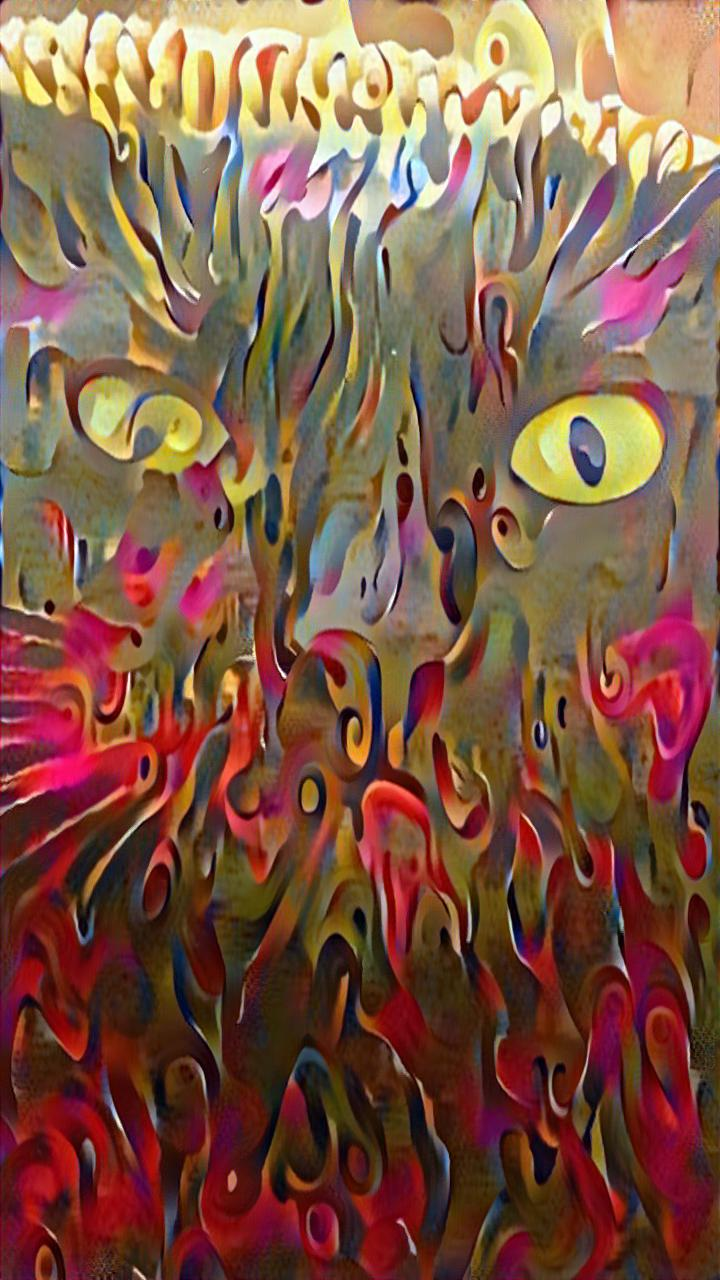

Bu fotoğraf ise 720p olarak üretildi. Zaman olarak ve görüntü olarak kesinlikle değmeyeceğine eminiz.
Yüksek çözünürlüklü fotoğraf elde etmek istiyorsak ya Resize etmeliyiz (önerilmez) ya da Super Resolution ile halledeceğiz. Onu da yarın sunacağım. Hepinizi beklerim. 

### Loss Konusu
Loss değerlerini herzaman düşük tutmak elbette daha iyi olacaktır. Ama burada bahsettiğimiz şey güzellik algısı olunca son kullanıcı açısından pek önemi kalmıyor. Çünkü güzellik estetik sanat göreceli.
Loss değeri çok yüksek olupda beğendiğim fotoğraflar benimde oldu. Ama bunu yüzdesel olarak vursaydık düşük bir yüzdeye sahip olurdu.

İlk başta ki sorduğum 2 adet resmi hatırladınız mı ? 
Orası Suriye. İç savaşın olduğu ve insanların birbirini kırdığı suriye.
Günahsız çocukların öldüğü suriye.
Stil Resimi merak ediyorsanız o da aşağıdaki gibi

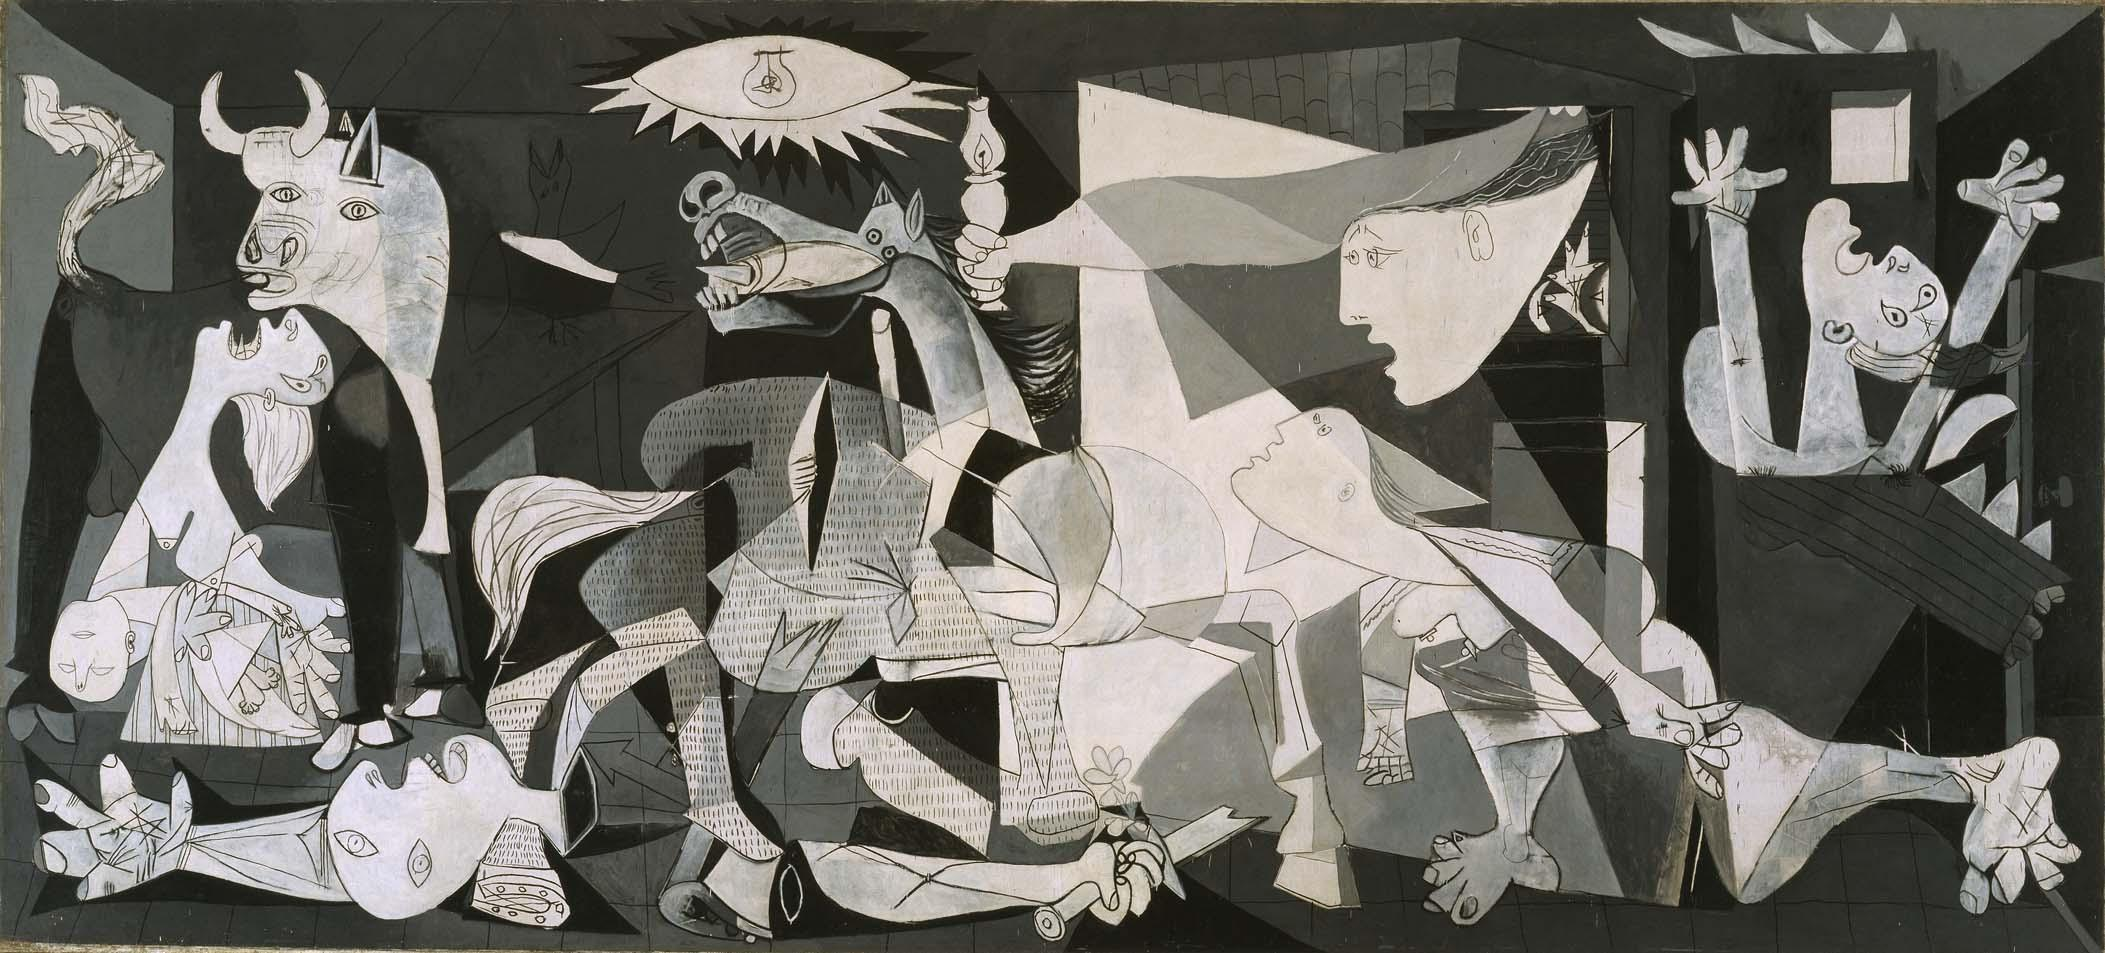

### Kapanış

Yukarıda ki tablo Picassoya ait. İsmi Guernica.
Kendisi İSPANYA İÇ SAVAŞI başta olmak üzere 2. DÜNYA SAVAŞI'nı da ele alıyor.
Lütfen bu tablonun hikayesini araştırın ve baştaki 2 fotoğrafa tekrar bakın pekçok benzer detay farkedeceksiniz. 
Fotoğrafların orijinal hallerini merak edenler için aşağıya bırakacağım.

Son olarak sunumu eleştirmenizi ve değerlendirmenizi arz ediyorum.

Sunumum bitmiştir bana ayırdığınız zaman için müteşşekiirim. Sağlıcakla ve sanatla kalın.

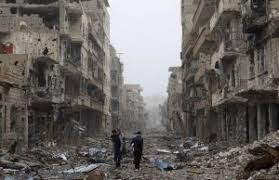

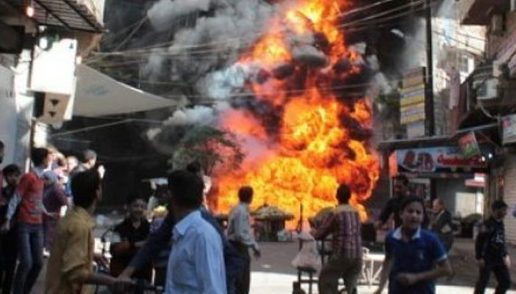